# Place Cell Analyses

Analyze TH data for place cells.

Cells of interest:
- No cells show clear / traditional place cell responses

In [1]:
%config Completer.use_jedi = False

In [2]:
import warnings
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from pynwb import NWBHDF5IO

from spiketools.spatial.occupancy import (compute_occupancy, compute_spatial_bin_edges,
                                          compute_spatial_bin_assignment)
from spiketools.spatial.utils import get_pos_ranges, get_bin_width
from spiketools.spatial.information import compute_spatial_information_2d
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import zscore_to_surrogates, compute_empirical_pvalue
from spiketools.plts.space import plot_positions, plot_heatmap
from spiketools.plts.stats import plot_surrogates
from spiketools.plts.utils import make_axes
from spiketools.utils import restrict_range, get_value_by_time_range
from spiketools.utils.trials import epoch_data_by_range

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append('../code')
from analysis import get_spike_positions, compute_bin_firing

## Settings

In [5]:
# Define the base data folder
data_folder = Path('/Users/tom/Documents/Data/JacobsLab/TH/')

In [6]:
# Define subject information
task = 'THF'
subj = 'wv001'
session = 2

In [7]:
# Define bins to use
#bins = [7, 21]
bins = [9, 12]

# Define minimum required occupancy (in seconds)
min_occ = 1

In [8]:
# Shuffle Settings
shuffle_approach = 'BINCIRC'
n_surrogates = 100

In [9]:
# Set example unit to analyze
uind = 9

## Load Data

In [10]:
# Define expected NWB file name & full path
file_name = '_'.join([task, subj, 'session_' + str(session)]) + '.nwb'
full_path = data_folder / 'NWB' / file_name

In [11]:
# Load NWB file
io = NWBHDF5IO(str(full_path), 'r')
nwbfile = io.read()

#### Extract Time Definitions

In [12]:
# Get the navigation time ranges
nav_starts = nwbfile.trials.navigation_start[:]
nav_stops = nwbfile.trials.navigation_stop[:]

#### Extract Position Data

In [13]:
# Extract the position data
ptimes = nwbfile.acquisition['position']['player_position'].timestamps[:]
positions = nwbfile.acquisition['position']['player_position'].data[:].T
stimes = nwbfile.processing['position_measures']['speed'].timestamps[:]
speed = nwbfile.processing['position_measures']['speed'].data[:]

In [14]:
# Get boundary ranges
x_boundary = nwbfile.acquisition['boundaries']['x_range'].data[:]
z_boundary = nwbfile.acquisition['boundaries']['z_range'].data[:]

# Add a buffer to the z-range (for tower transport)
z_boundary = z_boundary + np.array([-10, 10])

#### Extract Boundaries

In [15]:
# Collect together boundary ranges
area_range = [x_boundary, z_boundary]
print('X boundary range: ', x_boundary)
print('Z boundary range: ', z_boundary)

X boundary range:  [349.8549 419.8549]
Z boundary range:  [298.     419.3358]


#### Select position traces from navigation periods

In [47]:
# Get position data for navigation segments
ptimes_trials, positions_trials = epoch_data_by_range(ptimes, positions, nav_starts, nav_stops)
stimes_trials, speed_trials = epoch_data_by_range(stimes, speed, nav_starts, nav_stops)

In [48]:
# Recombine position data across selected navigation trials
ptimes = np.hstack(ptimes_trials)
positions = np.hstack(positions_trials)
stimes = np.hstack(stimes_trials)
speed = np.hstack(speed_trials)

#### Extract Spike Data

In [49]:
# Check the number of units & keep indices
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)
print('Number of units: {}'.format(n_units))
print('Number to keep:  {}'.format(n_keep))

Number of units: 81
Number to keep:  57


In [20]:
# Extract spikes for a unit of interest
spikes = nwbfile.units.get_unit_spike_times(uind)

## Position Data

In [21]:
# Compute position ranges
x_range, z_range = get_pos_ranges(positions)

In [22]:
# Check ranges of positon
print('Position X-range:  {:1.2f} - {:1.2f} ({:1.2f})'.format(*x_range, x_range[1] - x_range[0]))
print('Position Z-range:  {:1.2f} - {:1.2f} ({:1.2f})'.format(*z_range, z_range[1] - z_range[0]))

Position X-range:  365.40 - 404.59 (39.18)
Position Z-range:  302.87 - 411.54 (108.67)


In [23]:
# Get position values for each spike
spike_xs, spike_ys = get_spike_positions(spikes, ptimes, positions, threshold=0.1)
spike_positions = np.array([spike_xs, spike_ys])

In [24]:
# Check binning
x_bin_edges, y_bin_edges = compute_spatial_bin_edges(positions, bins, area_range)

In [25]:
# Check bin sizes
print('Bin widths: {:1.2f}, {:1.2f}'.format(get_bin_width(x_bin_edges), get_bin_width(y_bin_edges)))

Bin widths: 7.78, 10.11


### Occupancy

In [26]:
# Compute occupancy
occ = compute_occupancy(positions, ptimes, bins, speed, minimum=min_occ,
                        area_range=area_range, set_nan=True)

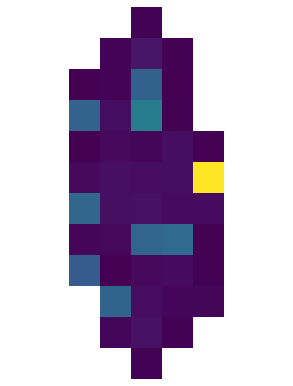

In [27]:
# Plot occupancy
plot_heatmap(occ, transpose=True, ignore_zero=False, figsize=(5, 7))

## Check spike locations

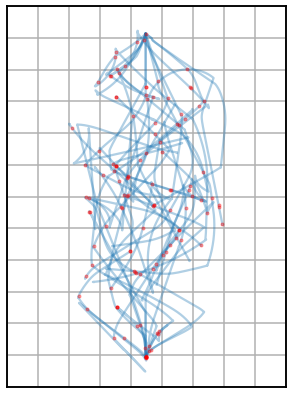

In [46]:
# Plot the map across all position traces (plotted per trial)
plot_positions(positions_trials, spike_positions,
               x_bins=x_bin_edges, y_bins=y_bin_edges,
               xlim=list(x_boundary), ylim=list(z_boundary),
               figsize=(5, 7))

## Compute Binned Spatial Firing

In [31]:
# Compute spatial bin assignments for each spike
x_binl, y_binl = compute_spatial_bin_assignment(spike_positions, x_bin_edges, y_bin_edges)

In [32]:
# Compute summary map of bin firing
bin_firing = compute_bin_firing(x_binl, y_binl, bins)

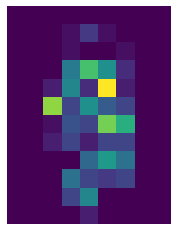

In [33]:
# Check the firing map
plot_heatmap(bin_firing, transpose=True)

In [34]:
# Normalize bin firing by occupancy
#with warnings.catch_warnings():
#    warnings.simplefilter("ignore")
normed_bin_firing = bin_firing / occ

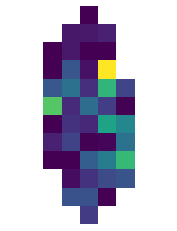

In [35]:
# Plot occupancy-normalized spatial firing
plot_heatmap(normed_bin_firing, transpose=True)

## Compute Spatial Information

In [36]:
# Compute the spatial information
spike_info = compute_spatial_information_2d(spike_xs, spike_ys, [x_bin_edges, y_bin_edges], occ)
print(spike_info)

1.7820316677570154


In [37]:
# Create shuffled time series for comparison
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates)

In [38]:
# Compute spatial information measures on surrogates
surrs = np.zeros(n_surrogates)
for ind, stimes in enumerate(times_shuffle):
    spike_xs, spike_ys = get_spike_positions(stimes, ptimes, positions)
    surrs[ind] = compute_spatial_information_2d(spike_xs, spike_ys, [x_bin_edges, y_bin_edges], occ)

In [39]:
# Compute the empirical p-value based on surrogates
surr_p_val = compute_empirical_pvalue(spike_info, surrs)

# Compute z-score of spatial information compared to surrogates
z_score = zscore_to_surrogates(spike_info, surrs)

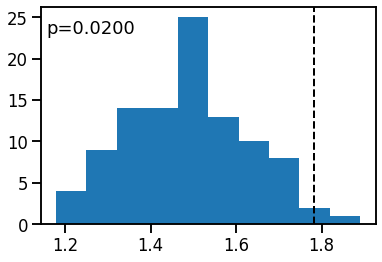

In [40]:
# Plot distribution of surrogates with measured empirical value
plot_surrogates(surrs, spike_info, surr_p_val)

## All Cells

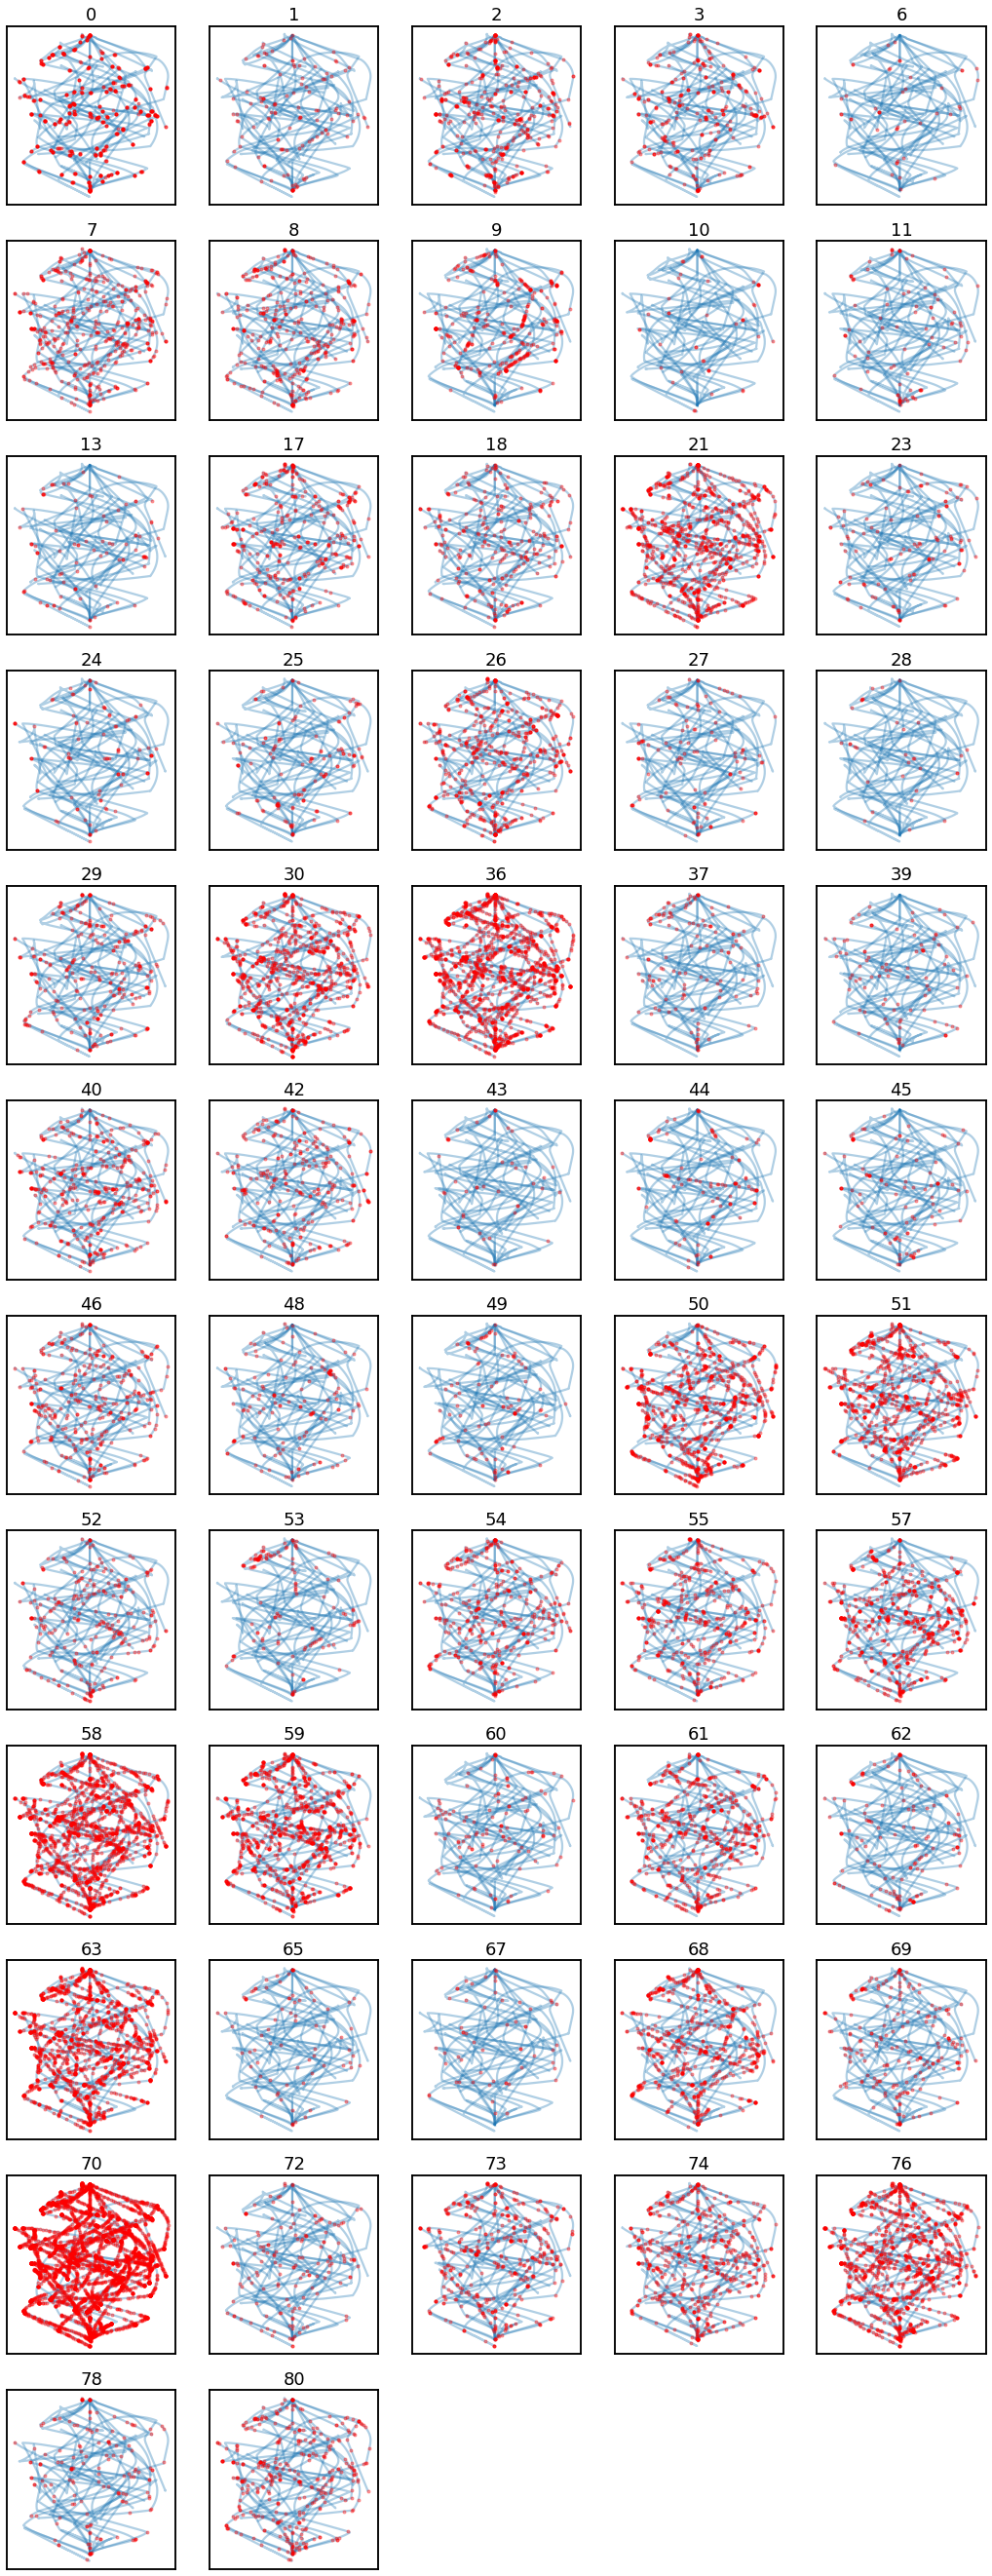

In [41]:
# Examine spatial firing across all cells
for ii, ax in zip(keep_inds, make_axes(n_keep)):
    
    spikes = nwbfile.units.get_unit_spike_times(ii)    
    spike_xs, spike_ys = get_spike_positions(spikes, ptimes, positions)
    
    plot_positions(positions_trials, np.array([spike_xs, spike_ys]), ax=ax)
    ax.set_title(ii)

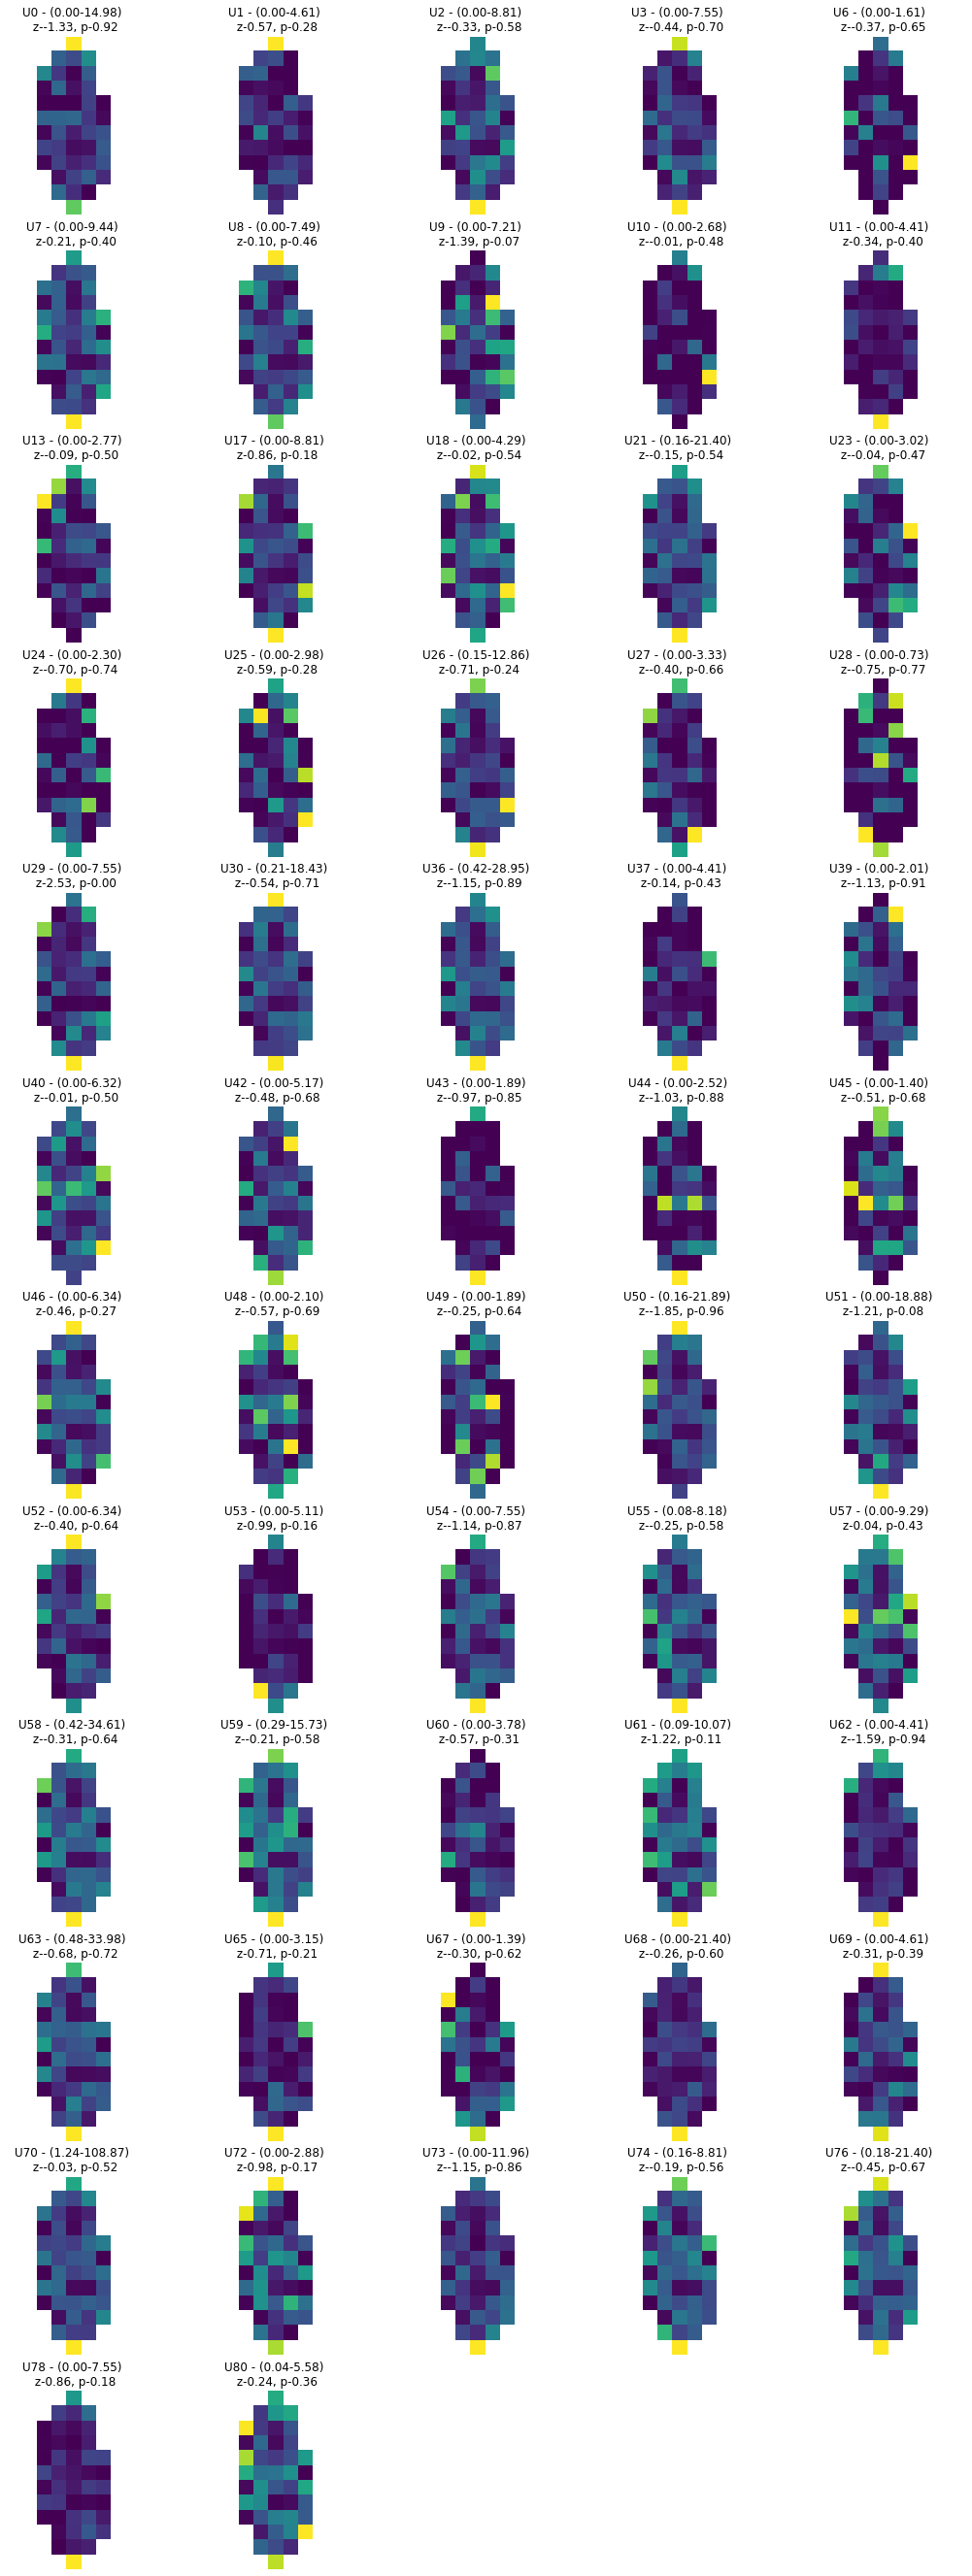

In [52]:
# Examine spatial firing across all cells
for ii, ax in zip(keep_inds, make_axes(n_keep)):
    
    spikes = nwbfile.units.get_unit_spike_times(ii)
    
    spike_xs, spike_ys = get_spike_positions(spikes, ptimes, positions)
    spike_positions = np.array([spike_xs, spike_ys])
    
    # Compute spatial bin assignments for each spike, and compute normalized bin firing
    x_binl, y_binl = compute_spatial_bin_assignment(spike_positions, x_bin_edges, y_bin_edges)
    bin_firing = compute_bin_firing(x_binl, y_binl, bins)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        normed_bin_firing = bin_firing / occ
    
    # Compute spatial information
    spike_info = compute_spatial_information_2d(spike_xs, spike_ys, [x_bin_edges, y_bin_edges], occ)
    
    # Create shuffled time series for comparison
    times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates)
    
    # Compute spatial information measures on surrogates
    surrs = np.zeros(n_surrogates)
    for ind, stimes in enumerate(times_shuffle):    
        spike_xs, spike_ys = get_spike_positions(stimes, ptimes, positions)
        surrs[ind] = compute_spatial_information_2d(spike_xs, spike_ys, [x_bin_edges, y_bin_edges], occ)
        
    # Compute z-score & p-value based on surrogates
    z_score = zscore_to_surrogates(spike_info, surrs)
    surr_p_val = compute_empirical_pvalue(spike_info, surrs)

    # Plot occupancy-normalized spatial firing
    plot_heatmap(normed_bin_firing, transpose=True, ax=ax)
    
    color = 'red' if surr_p_val < 0.05 else 'black'
    title = 'U{} - ({:1.2f}-{:1.2f}) \n z-{:1.2f}, p-{:1.2f}'.format(\
        ii, np.nanmin(normed_bin_firing), np.nanmax(normed_bin_firing), z_score, surr_p_val)
    ax.set_title(title, fontdict={'fontsize' : 12})